In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# download the dataset
!git clone https://github.com/amalshaji/xraydataset

Cloning into 'xraydataset'...
remote: Enumerating objects: 634, done.
remote: Total 634 (delta 0), reused 0 (delta 0), pack-reused 634
Receiving objects: 100% (634/634), 209.85 MiB | 52.46 MiB/s, done.
Resolving deltas: 100% (2/2), done.


### Dataset Link: [X-Ray Dataset](https://github.com/amalshaji/xraydataset)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *

### Data

In [ ]:
path = Path('xraydataset')

In [ ]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings'], 2, 500, 125)

In [ ]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 500
Number of examples in validation: 125


In [ ]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

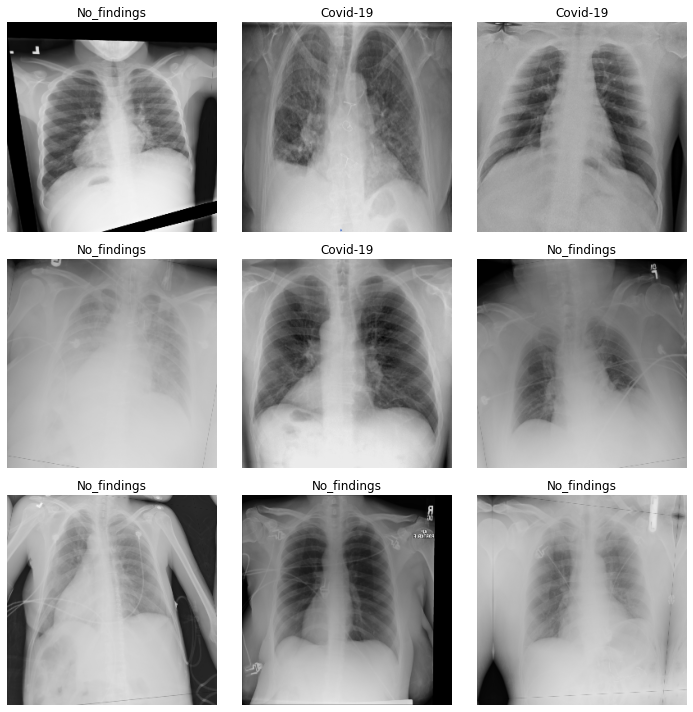

In [ ]:
#Sample images from the dataset
data.show_batch(rows=3, figsize=(10,10))

## Model

In [ ]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [ ]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [ ]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [ ]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Linear(338, 2)
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [ ]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.443519,0.724334,0.200000,00:22
1,0.358368,0.672559,0.544000,00:22
2,0.308243,0.236158,0.960000,00:22
3,0.261225,0.169599,0.936000,00:22
4,0.228023,0.113032,0.968000,00:22
5,0.208042,0.061111,0.976000,00:22
6,0.198747,0.144616,0.952000,00:22
7,0.194238,0.060636,0.968000,00:22
8,0.190523,0.074588,0.960000,00:22
9,0.175069,0.340050,0.920000,00:22


In [ ]:
 print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 125


In [ ]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

In [ ]:
accuracy(probs,targets)

tensor(0.9680)

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings'], 2, 500, 125)

In [ ]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings']
print(classification_report(y_true1, y_pred1, target_names=target_names))

125 121 0.968
[[ 21   4]
 [  0 100]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.84      0.91        25
 No_findings       0.96      1.00      0.98       100

    accuracy                           0.97       125
   macro avg       0.98      0.92      0.95       125
weighted avg       0.97      0.97      0.97       125



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

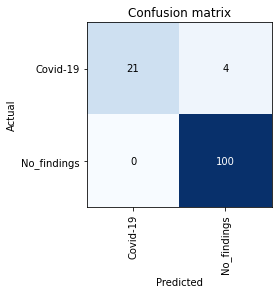

In [ ]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);